## Source:
1.  http://nlp.seas.harvard.edu/annotated-transformer/#background
2.  https://github.com/harvardnlp/annotated-transformer/blob/master/AnnotatedTransformer.ipynb

In [1]:
import os
from os.path import exists
import math
import copy
import time

import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets

import pandas as pd
import altair as alt
import spacy
import GPUtil
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [2]:
# Convenience helper functions

def is_interactive_notebook():
    return __name__ == "__main__"

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)
    
def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)
        
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None
    
    def step(self):
        None
        
    def zero_grad(self, set_to_none=False):
        None

class DummyScheduler:
    def step(self):
        None

## Model Utils

In [3]:
def clones(module, N):
    """
    Return the N identical layers be it encoder or decoder
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class LayerNorm(nn.Module):
    """
    compute the layer normalization. Pytorch function can be used here for simplicity.
    """
    def __init__(self, features, eps= 1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim= True)
        std = x.std(-1, keepdim= True)
        return self.a_2 * (x-mean)/ (std + self.eps) + self.b_2
    
class SubLayerConnection(nn.Module):
    """
    Code for residual connections and layer norms
    
    """
    
    def __init__(self, size, prob):
        super(SubLayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(prob)
        
    def forward(self, x, sub_layer):
        return x + self.dropout(sub_layer(self.norm(x)))
    
def attention(query, key, value, mask=None, dropout= None):
    d_q = query.size(-1)
    unnorm_attention_weights = torch.matmul(query, key.transpose(-2, -1))/ math.sqrt(d_q)
    if mask is not None:
        unnorm_attention_weights = unnorm_attention_weights.masked_fill(mask == 0, 1e-9)
    attention_weights = unnorm_attention_weights.softmax(dim= -1)
    if dropout is not None:
        attention_weights = dropout(attention_weights)
    return torch.matmul(attention_weights, value), attention_weights

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, p_dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.d_k = d_model//h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=p_dropout)
    
    def forward(self, q, k, v, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = q.shape[0]
        
        # Apply linear layers
        q, k, v = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (q, k, v))
        ]
        
        # Apply attention
        x, self.attn = attention(q, k, v, mask = mask, dropout=self.dropout)
        
        # Concatenate
        x = (x.transpose(1,2).contiguous().view(nbatches, -1, self.h*self.d_k))
        del q
        del k
        del v
        return self.linears[-1](x)

In [4]:
def subsequent_mask(size):
    """
    Mask the subsequent positions for the decoder. So it has no glimpse of future
    """
    attn_shape = (1, size, size)
    sub_mask = np.triu(np.ones(attn_shape), k=1).astype(np.uint8)
    return torch.from_numpy(sub_mask) == 0

## Overall encoder-decoder architecture of Transformer

In [5]:
# Encoder-Decoder
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    

class Generator(nn.Module):
    """
    MLP and Softmax for the decoder output in transformer architecture
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return log_softmax(self.proj(x), dim= -1)

## Encoder

In [6]:
class Encoder(nn.Module):
    """
    Encoder definition with N encoderlayers.
    Encoder layer is defined as a seperate module.
    """
    
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        x = self.norm(x)
        return x

class EncoderLayer(nn.Module):
    """
    Definition of each Encoder layer i.e., Multi Head Attention and Feed Forward layer.
    """
    
    def __init__(self, size, self_attn, feed_forward, p_dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, p_dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        x = self.sublayer[1](x, self.feed_forward)
        return x
    

## Deocder

In [7]:
class Decoder(nn.Module):
    """
    Decoder definition with N decoder layers
    Decoeder layer is defined as a seperate module
    """
    
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, encoder_op, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_op, src_mask, tgt_mask)
        x = self.norm(x)
        return x
        
class DecoderLayer(nn.Module):
    """
    Definition of each Decoder Layer i.e., two Multi Head Attentions (with and without mask) and Feed Forward layer
    """
    def __init__(self, size, self_attn, feed_forward, src_attn, p_dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, p_dropout), 3)
    
    def forward(self, x, encoder_op, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, encoder_op, encoder_op, src_mask))
        x = self.sublayer[2](x, self.feed_forward)
        return x

## Position wise feed forward

In [8]:
class PositionwiseFeedForward(nn.Module):
    """
    Feed forward layers in encoder and decoder, applied to each position seperately.
    """
    def __init__(self, d_model, d_ff, p_dropout = 0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(p_dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## Embeddings and Pos encoding

In [9]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.embed = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model)

In [10]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model, p_dropout, max_len=5000):
        super(PositionEncoding, self).__init__()
        self.dropout = nn.Dropout(p_dropout)
        
        pos_embed = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        divider = torch.exp(torch.arange(0, d_model, 2) * (-(math.log(10000.)/d_model)))
        
        pos_embed[:, 0::2] = torch.sin(pos * divider)        
        pos_embed[:, 1::2] = torch.cos(pos * divider)
        pos_embed = pos_embed.unsqueeze(0)
        self.register_buffer("pos_embed", pos_embed)
        
    def forward(self, x):
        x += self.pos_embed[:,: x.size(1)].requires_grad_(False)
        x = self.dropout(x)
        return x

In [11]:
def Transformer(src_vocab, tgt_vocab, N=6, d_model=512, h=8, p_dropout=0.1, d_ff=2048):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    pwff = PositionwiseFeedForward(d_model, d_ff, p_dropout)
    pos_embed = PositionEncoding(d_model, p_dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(pwff), p_dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(pwff), c(attn), p_dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(pos_embed)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(pos_embed)),
        Generator(d_model, tgt_vocab),
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [12]:
def inference_test():
    test_model = Transformer(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 2, 6, 6, 6, 6, 6, 6, 6, 6]])
Example Untrained Model Prediction: tensor([[0, 6, 6, 6, 6, 6, 6, 6, 6, 6]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 9, 1, 5, 6, 1, 5, 5, 5, 5]])
Example Untrained Model Prediction: tensor([[ 0, 10,  7,  5,  5,  5,  5,  5,  5,  5]])
Example Untrained Model Prediction: tensor([[0, 2, 3, 3, 3, 3, 3, 3, 3, 3]])
Example Untrained Model Prediction: tensor([[0, 5, 6, 6, 6, 6, 6, 6, 6, 6]])
Example Untrained Model Prediction: tensor([[0, 6, 6, 6, 5, 5, 5, 5, 5, 5]])
Example Untrained Model Prediction: tensor([[0, 3, 2, 4, 0, 3, 0, 3, 0, 3]])
Example Untrained Model Prediction: tensor([[ 0, 10,  7,  3,  2,  8,  3,  2,  6,  8]])


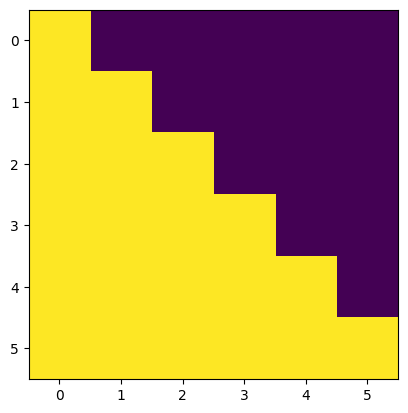

In [13]:
plt.figure()
plt.imshow(subsequent_mask(6)[0])
plt.show()

In [14]:
x = subsequent_mask(3)
print(x[0])

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])


## Training

In [15]:
class Batch:
    """
    The object of this class holds the src and target sentences and also constructs the masks.
    """
    def __init__(self, src, tgt = None, pad = 0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask

In [16]:
class TrainState:
    step: int = 0
    accum_step: int = 0
    samples: int = 0
    tokens: int = 0

In [28]:
def run_epoch(iterator, model, loss_fn, optimizer, scheduler, mode='train', accum_iter=1, train_state=TrainState()):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(iterator):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_fn(out, batch.tgt_y, batch.ntokens)
        if mode == 'train':
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i% accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

In [18]:
def rate(step, model_size, factor, warmup):
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step**(-0.5), step * warmup ** (-1.5))
    )

In [ ]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

What is Label Smoothing?

In [ ]:
# Label smoothing
class LabelSmoothing(nn.Module):
    
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist =  x.data.clone()
        true_dist.fill_(self.smoothing/ (self.size-2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

In [ ]:
def example_label_smoothing():
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor(
        [
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
        ]
    )
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "target distribution": crit.true_dist[x, y].flatten(),
                    "columns": y,
                    "rows": x,
                }
            )
            for y in range(5)
            for x in range(5)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect(color="Blue", opacity=1)
        .properties(height=200, width=200)
        .encode(
            alt.X("columns:O", title=None),
            alt.Y("rows:O", title=None),
            alt.Color(
                "target distribution:Q", scale=alt.Scale(scheme="viridis")
            ),
        )
        .interactive()
    )


show_example(example_label_smoothing)

alt.Chart(...)

In [22]:
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data


In [23]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

In [24]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

In [25]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

In [29]:

def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = Transformer(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


execute_example(example_simple_model)

Epoch Step:      1 | Accumulation Step:   2 | Loss:   3.07 | Tokens / Sec:  3678.5 | Learning Rate: 5.5e-06
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.01 | Tokens / Sec:  4249.7 | Learning Rate: 6.1e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.69 | Tokens / Sec:  4245.2 | Learning Rate: 1.2e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.44 | Tokens / Sec:  4221.7 | Learning Rate: 1.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.07 | Tokens / Sec:  4234.8 | Learning Rate: 2.3e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.61 | Tokens / Sec:  4213.8 | Learning Rate: 2.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.37 | Tokens / Sec:  4237.1 | Learning Rate: 3.4e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.25 | Tokens / Sec:  4276.5 | Learning Rate: 3.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.10 | Tokens / Sec:  4246.9 | Learning Rate: 4.5e-04
Epoch Step:      1 | Accumul